In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib.colors import LogNorm

In [2]:
from BurstSim.GRB import *
from BurstSim.Detector import *
from BurstSim.Spacecraft import *
from BurstSim.Stats import calcNorms, addErrors, calcNormsWithError

In [3]:
mpl.rcParams.update({'font.size': 22})

In [4]:
pointings = {'01': ('90:0:0','5:0:0'),
            '02': ('180:0:0','10:0:0'),
            '03': ('270:0:0','15:0:0'),
            '04': ('360:0:0','20:0:0')}

In [5]:
spacecraft = Spacecraft(pointings, window = 0.1)

In [74]:
for det in spacecraft.detectors:
    print det.name,det.azimuth, det.altitude,det.zenith

02 180:00:00.0 80:00:00.0 10:00:00.0
03 270:00:00.0 75:00:00.0 15:00:00.0
01 90:00:00.0 85:00:00.0 5:00:00.0
04 360:00:00.0 70:00:00.0 20:00:00.0


In [77]:
120*30

3600

In [6]:
#res = (12,3)
res = (60,15)
#res = (120,30)

In [7]:
aa,ll = np.meshgrid(np.linspace(0,360,res[0],endpoint=False),np.linspace(0,90,res[1]))
training_positions = np.vstack([aa.ravel(),ll.ravel()])

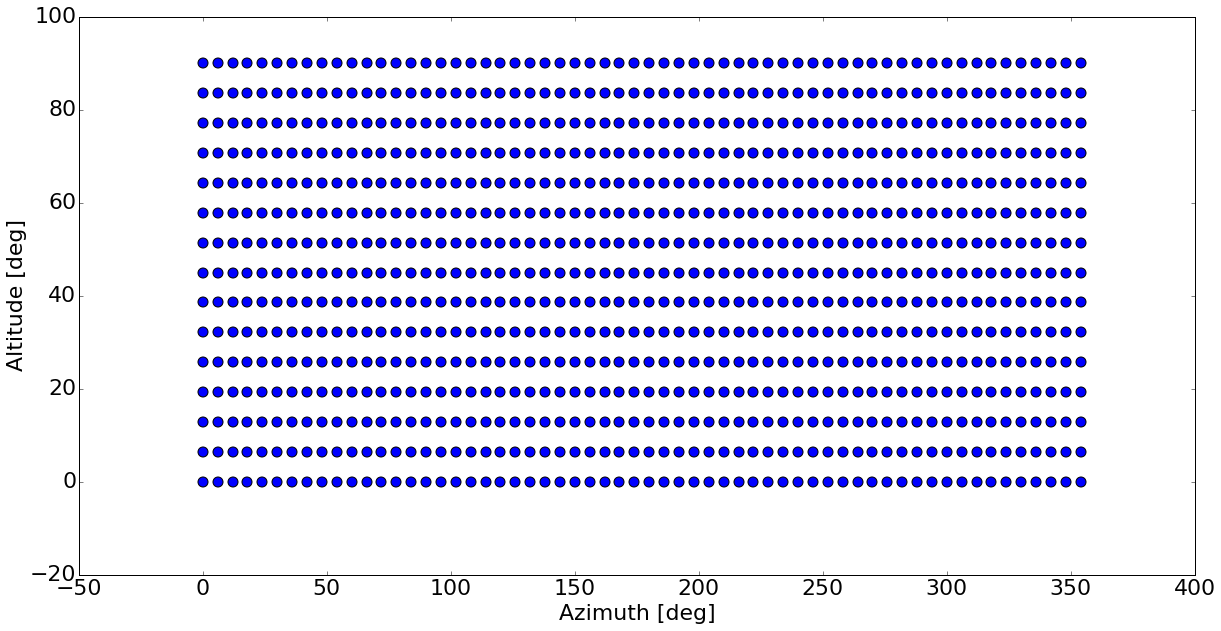

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(aa,ll,s=100.)
plt.xlabel('Azimuth [deg]')
plt.ylabel('Altitude [deg]')
plt.show()

In [9]:
radec_array  = np.array([spacecraft._dummyDet.obs.radec_of(position[0]*np.pi/180.,position[1]*np.pi/180.) 
                         for position in training_positions.T])

In [11]:
d = spacecraft._dummyDet.obs.radec_of(0,71.*np.pi/180.)

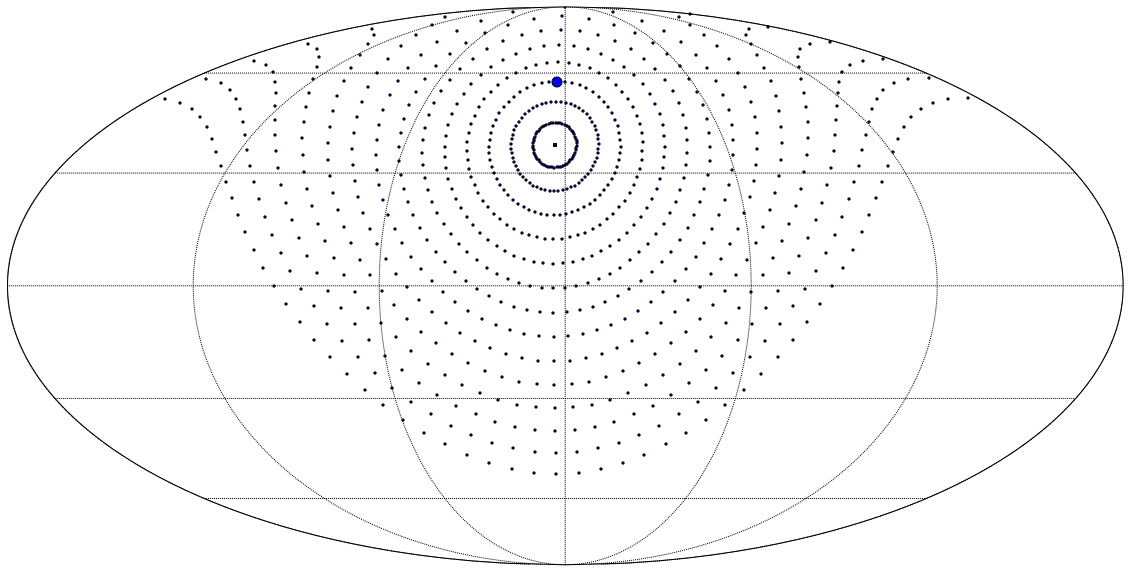

In [12]:
plt.figure(figsize=(20,10))
m = Basemap(projection='moll',lon_0=180,resolution='c')
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
x,y = m(radec_array[:,0]*180./np.pi,radec_array[:,1]*180./np.pi)
x1,y1 = m(d[0]*180./np.pi, d[1]*180./np.pi)
m.scatter(x,y,marker='.')
m.scatter(x1,y1,marker='o',s=100.)
plt.show()

In [13]:
exposures = np.array([[detector.exposure(position[0]*180./np.pi,position[1]*180./np.pi) for position in radec_array] 
                      for detector in spacecraft.detectors])

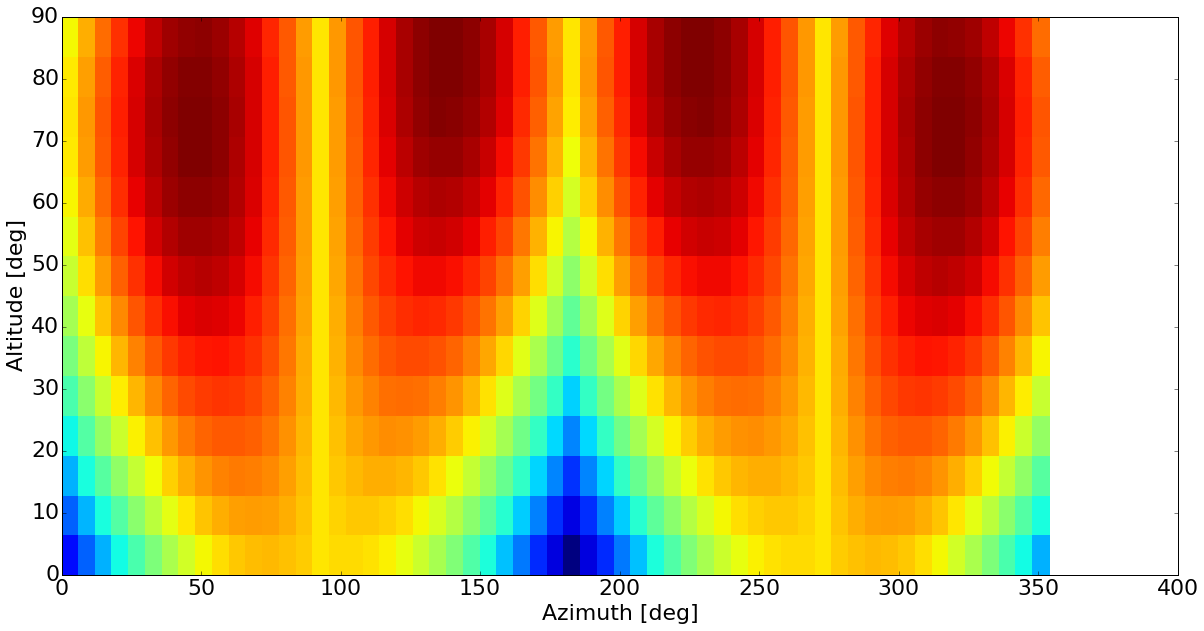

In [14]:
plt.figure(figsize=(20,10))
plt.pcolormesh(aa,ll,exposures.sum(axis=0).reshape((res[::-1])))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Altitude [deg]')
plt.show()

In [15]:
rr = (radec_array[:,0].reshape(res[::-1]))*180./np.pi
dd = (radec_array[:,1].reshape(res[::-1]))*180./np.pi

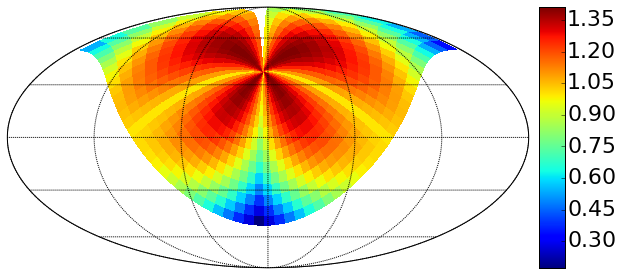

In [16]:
plt.figure(figsize=(10,20))
m = Basemap(projection='moll',lon_0=180,resolution='c')
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
x,y = m(rr,dd)
m.pcolormesh(x,y,exposures.sum(axis=0).reshape(res[::-1]))
m.colorbar()
plt.show()

In [17]:
training_grbs = [GRB(position[0]*180./np.pi,position[1]*180./np.pi,binz=.001) 
                 for position in radec_array[exposures.sum(axis=0) > 0.]]

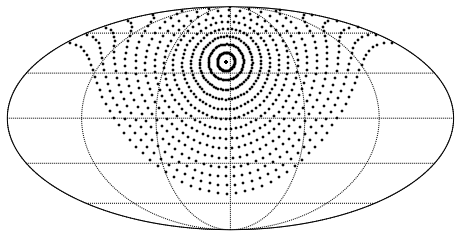

In [18]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in training_grbs])
plt.figure(figsize=(8,10))
m = Basemap(projection='moll',lon_0=180,resolution='c')
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
x,y = m(pos[:,0],pos[:,1])
m.scatter(x,y,3,marker='o',color='k')
plt.show()

In [19]:
training_counts = spacecraft.throw_grbs(training_grbs,scaled=True)

BurstSim/Spacecraft.py:80: RuntimeWarning: invalid value encountered in divide
  for idx,rec in enumerate(grb_rec)]


In [78]:
360*100

36000

In [46]:
#real_res = (360,100)
real_res = (90,25)
raa,rll = np.meshgrid(np.linspace(1,361,real_res[0],endpoint=False),np.linspace(1,101,real_res[1]))
real_positions = np.vstack([raa.ravel(),rll.ravel()])


In [47]:
real_pos_radec  = np.array([spacecraft._dummyDet.obs.radec_of(position[0]*np.pi/180.,position[1]*np.pi/180.) 
                         for position in real_positions.T])

In [48]:
exposures = np.array([[detector.exposure(position[0],position[1]) for position in real_pos_radec*180./np.pi]
                      for detector in spacecraft.detectors])

In [49]:
real_grbs = [GRB(position[0]*180./np.pi,position[1]*180./np.pi,binz=0.001) 
             for position in real_pos_radec[exposures.sum(axis=0) > 0.]]

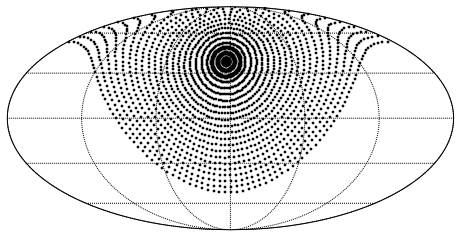

In [50]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in real_grbs])
plt.figure(figsize=(8,10))
m = Basemap(projection='moll',lon_0=180,resolution='c')
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
x,y = m(pos[:,0],pos[:,1])
m.scatter(x,y,3,marker='o',color='k')
plt.show()

In [51]:
real_counts = spacecraft.throw_grbs(real_grbs, scaled=True)

In [52]:
norms = calcNorms(real_counts,training_counts)

In [53]:
real_counts_err = addErrors(real_counts,training_counts)

In [54]:
norms_errp, norms_errm = calcNormsWithError(real_counts,training_counts,real_counts_err)

In [55]:
loc_mins = [norm.argmin() for norm in norms]
loc_mins_errm = [norm.argmin() for norm in norms_errm]
loc_mins_errp = [norm.argmin() for norm in norms_errp]

In [56]:
errors = [eph.separation(grb.eph,training_grbs[loc_mins[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]
errors_errm = [eph.separation(grb.eph,training_grbs[loc_mins_errm[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]
errors_errp = [eph.separation(grb.eph,training_grbs[loc_mins_errp[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]

[]

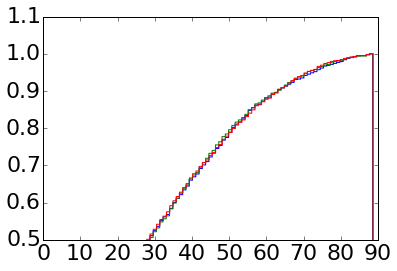

In [57]:
hist_data = plt.hist(errors,bins=100,normed=1, histtype='step', cumulative=True)
hist_data_errm = plt.hist(errors_errm,bins=100,normed=1, histtype='step', cumulative=True)
hist_data_errp = plt.hist(errors_errp,bins=100,normed=1, histtype='step', cumulative=True)
plt.plot()

In [58]:
avg_stat = np.average([hist_data_errm[1][np.abs(hist_data_errm[0] - 0.68).argmin()],
                       hist_data_errp[1][np.abs(hist_data_errp[0] - 0.68).argmin()]])

In [59]:
np.average(errors)

32.301127301938266

In [60]:
print 'Systematic Error: {:,.2f}'.format(hist_data[1][np.abs(hist_data[0] - 0.68).argmin()])

Systematic Error: 41.02


In [61]:
print 'Statistical Error: {:,.2f}'.format(avg_stat)

Statistical Error: 40.60


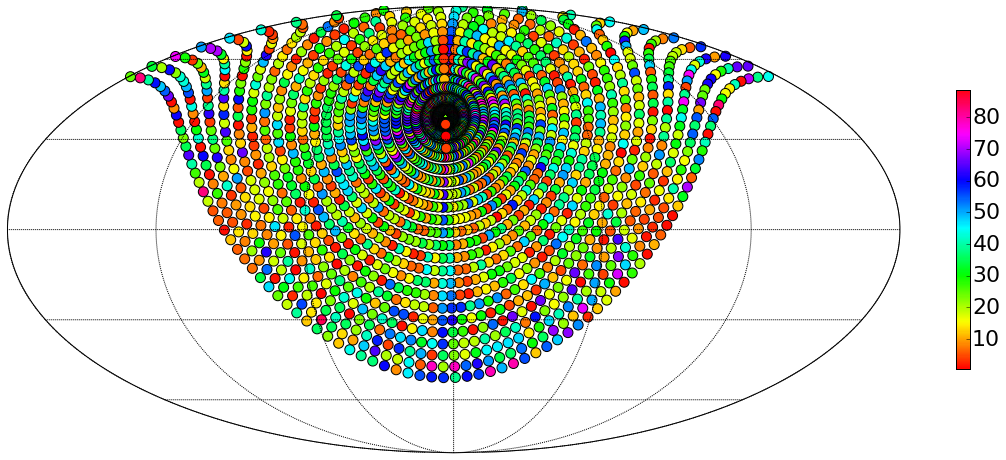

In [62]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in real_grbs])
plt.figure(figsize=(20,10))
m = Basemap(projection='moll',lon_0=180,resolution='c')
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
x,y = m(pos[:,0],pos[:,1])
#m.scatter(x,y,marker='o',c=errors, s=np.array(errors)*10,cmap=plt.cm.hsv)
m.scatter(x,y,marker='o',c=errors,s=100.,cmap=plt.cm.hsv)
plt.colorbar(shrink=0.5)
#plt.savefig('Sky Map with Errors.pdf', transparent = True)
plt.show()

In [63]:
pos = np.array([[grb.eph.az*180./np.pi,grb.eph.alt*180./np.pi] for grb in real_grbs])

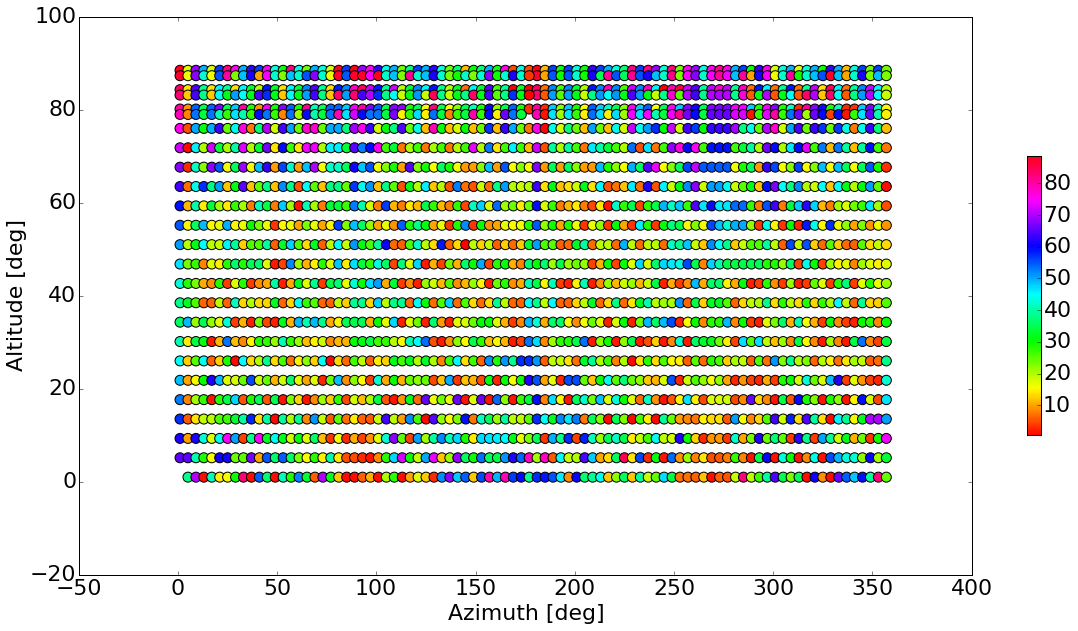

In [64]:
plt.figure(figsize=(20,10))
plt.scatter(pos[1:-1,0],pos[1:-1,1],s=100.,c=errors[1:-1], cmap=plt.cm.hsv)
plt.xlabel('Azimuth [deg]')
plt.ylabel('Altitude [deg]')
plt.colorbar(shrink=0.5)
plt.show()

In [40]:
import pickle
output = open('data/az_el_raa.p', 'wb')
pickle.dump(raa, output)
output.close()

In [41]:
output = open('data/az_el_rll.p', 'wb')
pickle.dump(rll, output)
output.close()

In [42]:
output = open('data/az_el_errors.p', 'wb')
pickle.dump(errors, output)
output.close()

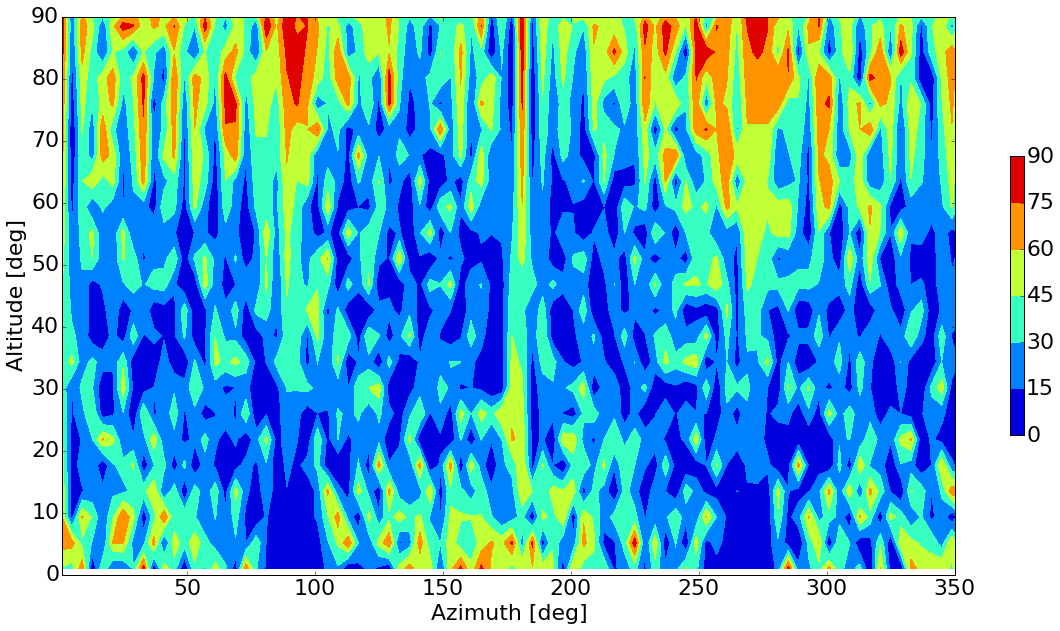

In [75]:
plt.figure(figsize=(20,10))
plt.contourf(raa,rll,np.reshape(errors,real_res[::-1]),5)
plt.xlabel('Azimuth [deg]')
plt.ylabel('Altitude [deg]')
plt.xlim((1,350))
plt.ylim((0,90))
plt.colorbar(shrink=0.5)
#plt.savefig('Plots/Sky Map with Errors Az El.pdf', transparent = True)
plt.show()

In [66]:
az = np.linspace(80.,10.,num=1000.)

In [67]:
summed = 0.
for angle in az:
    avg = np.average((np.reshape(errors,real_res[::-1]))[rll<angle])*np.sin((90.-angle)*(np.pi/180.))
    summed += avg
    #print angle,avg
print summed / np.shape(az)

[ 18.20889809]
